# Semantic Segmentation

In this notebook, you will train a simple U-Net for semantic segmentation of hand-written digits on the M2NIST dataset. The U-Net uses batch normalization. And to handle the large class imbalance (because most pixels do not belong to a digit), we use a focal loss.

Further Informations:
- U-Net: Convolutional networks for biomedical image segmentation"  
  Ronneberger et al. (2015) MICCAI  
  https://arxiv.org/abs/1505.04597
- M2NIST:  
  https://www.kaggle.com/datasets/farhanhubble/multimnistm2nist
- Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift  
  Ioffe and Szegedy (2015) arXiv  
  https://arxiv.org/abs/1502.03167
- Focal Loss for Dense Object Detection  
  Lin et al. (2018) arXiv  
  https://arxiv.org/abs/1708.02002

--- Alessandro Motta, 8th of November 2023

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models, utils, Model

In [ ]:
# Get the data
!curl -L https://github.com/michelucci/HSLU-CASML2-Deep_Learning/raw/main/COMPUTER-VISION/datasets/m2nist.zip -o /tmp/m2nist.zip
!unzip /tmp/m2nist.zip -d /tmp/m2nist

## Load the M2NIST Dataset

In [ ]:
images = np.load('/tmp/m2nist/combined.npy')
segmentations = np.load('/tmp/m2nist/segmented.npy')

images = images.astype(dtype=np.float32) / 255 # from 0-255 to 0-1
segmentations = segmentations.astype(dtype=np.float32) # 0, 1

# Splitting into training and test sets
train_mask = np.random.uniform(size=len(images)) < 0.75

train_images = images[train_mask]
train_segmentations = segmentations[train_mask]

test_images = images[~train_mask]
test_segmentations = segmentations[~train_mask]

del images
del segmentations

In [ ]:
train_images.shape
train_segmentations.shape

## Inspect the Dataset

In [ ]:
sample_id = 0
image = test_images[sample_id]
segmentation = test_segmentations[sample_id]
segmentation = np.split(segmentation, segmentation.shape[-1], axis=segmentation.ndim-1)

plt.figure(figsize=(12, 3))
plt.subplot(1, 12, 1)
plt.title("Image")
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.gca().set_axis_off()

for i, seg in enumerate(segmentation):
  plt.subplot(1, 12, 2+i)

  plt.title(str(i) if i < 10 else "BG")
  plt.imshow(seg, cmap='gray', vmin=0, vmax=1)
  plt.gca().set_axis_off()

plt.show()

## Build U-Net-like Model

Here, we build a simple U-Net-like model.

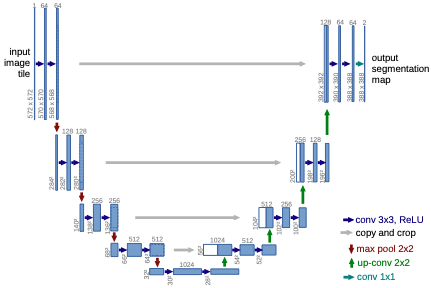

This model architecture roughly consists of three parts:
- the downsampling (encoder) path on the left,
- the upsampling (decoder) paths on the right, and
- "skip connections" that skip the encoder and directly feed the decoder.

This way, the decoder has access to both
- high-level, but low-resolution information (e.g., which digit) that got extracted by the full encoder path, and
- low-level, but high-resolution information (e.g., width of stroke) that was not downsampled.

For more details, have a look at the original paper linked at the top.

In [ ]:
def build_down(input, num_features):
  x = input
  outputs = []
  for level, features in enumerate(num_features):
    if level > 0:
      x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.Conv2D(features, (5, 5), strides=(1, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    outputs.append(x)
  return outputs

def build_up(down, num_outputs):
  x = down[-1]
  for level, skip in reversed(list(enumerate(down[:-1]))):
    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Concatenate(axis=3)([x, skip])

    if level > 0:
      x = layers.Conv2D(skip.shape[-1], (5, 5), strides=(1, 1), activation='relu', padding='same')(x)
      x = layers.BatchNormalization(axis=3)(x)
    else:
      x = layers.Conv2D(num_outputs, (1, 1), activation='sigmoid')(x)

  return x

def build_model(input_shape, num_features, num_outputs):
  input = layers.Input(shape=input_shape)
  down = build_down(input, num_features)
  output = build_up(down, num_outputs)

  model = Model(inputs=input, outputs=output)
  model.compile(loss='binary_focal_crossentropy', optimizer='adam')
  return model

model = build_model([64, 84, 1], [12, 12, 12], 11)

In [ ]:
model.summary()

In [ ]:
utils.plot_model(model, rankdir='LR')

## Train the Model
Work in pairs:

- One person person trains the model as described above.
- The other person removes the batch normalization and then trains the mode.

Compare the two trainings. Can you observe any differences?

In [ ]:
def show_predictions(model, image):
  preds = model.predict(np.expand_dims(image, axis=0), verbose=False)[0]
  preds = np.split(preds, preds.shape[-1], axis=preds.ndim-1)

  plt.figure(figsize=(12, 3))
  plt.subplot(1, 12, 1)
  plt.title("Input")
  plt.imshow(image, cmap='gray')
  plt.gca().set_axis_off()

  for i, pred in enumerate(preds):
    plt.subplot(1, 12, 2+i)

    plt.title(str(i) if i < 10 else "BG")
    plt.imshow(pred, cmap='gray', vmin=0, vmax=1)
    plt.gca().set_axis_off()

  plt.show()

In [ ]:
epochs = 0
while True:
  print(f"Epoch {epochs}")
  show_predictions(model, test_images[0])

  model.fit(
    train_images, train_segmentations,
    epochs=1, verbose=1, batch_size=16,
  )

  epochs += 1
  print()